In [1]:
import numpy as np
import matplotlib.pyplot as plt
from leptotools import momentumDep as mdp

from leptotools.SMconstants import Tsph
from scipy.integrate import odeint

### List of momentum modes

In [2]:
Nmodes=10
klist=np.linspace(0,8,Nmodes+1)[1:]   # Skip the first mode - it is singular
wlist=np.ones(len(klist))*(klist[1]-klist[0])

kquad, wquad=np.polynomial.laguerre.laggauss(Nmodes)
#klist=kquad
#wlist=wquad
print(klist)
print(repr(wlist))

wlist = np.array([0.4, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.4])

[0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]
array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8])


# Set HNL masses

In [3]:
MHNL=2 #GeV

### JIT accelerated rates

In [4]:
(gP, gM) = mdp.interpFast(MHNL, klist)

In [5]:
%timeit gP(-3)

The slowest run took 8.25 times longer than the fastest. This could mean that an intermediate result is being cached.
5.6 µs ± 6.66 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


thermal masses function:

In [6]:
(hp,hm) = mdp.interpHFast(MHNL,klist)

In [7]:
%timeit hp(-3)

2.3 µs ± 26.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Equation setup

In [8]:
from leptotools.lepto import M2UpsGen, heven, hodd
from leptotools.scantools import leptogenesisScanSetup
ls = leptogenesisScanSetup(2)

ls.set_ordering('NO')
#ls.set_dM(3e-10)
ls.set_dM(3e-5)
ls.set_romega(np.pi/4)
ls.set_iomega(4.1)
ls.set_delta(np.pi)
ls.set_eta(1.5*np.pi)
ls.set_xi(1)
ls.set_CI()

In [9]:
Tplt=np.logspace(8,2,500)
zetaPlt=np.log(Tsph/Tplt)

ls.set_HeffGammaR()
ls.set_initial_condition()
ls.set_odesol(Tplt)

In [10]:
from leptotools.SMconstants import *

In [11]:
UpsWPGnn, UpsWMGnn, UpsPGnn, UpsMGnn, UpsPHnn, UpsMHnn, M2Hnn = M2UpsGen(ls.MN,ls.Y,dM=ls.dM)

In [12]:
yM=mdp.yukawaMatrices(ls.Y,ls.MN)


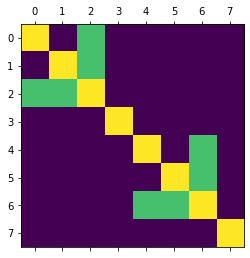

In [13]:
plt.matshow(UpsPGnn[:8,:8])
plt.show()
#plt.matshow(UpsPGnn[8:11,:8])
#plt.show()
#plt.matshow(UpsWPGnn[:8,8:11])
#plt.show()



### Tests of momentum-averaging

$h$-averaging

In [14]:
from leptotools.rates import nF

In [15]:
def hPAvgTest(zeta):
    m=ls.Mb/Tsph*np.exp(zeta)
    fN=1/(np.exp(np.sqrt(klist**2+m**2))+1)
    #T=np.exp(-zeta)*Tsph
    hPvec=hp(zeta)
    return np.dot(wlist,hPvec*klist**2*fN)/(2*np.pi**2)/nF(m)

def hMAvgTest(zeta):
    m=ls.Mb/Tsph*np.exp(zeta)
    fN=1/(np.exp(np.sqrt(klist**2+m**2))+1)
    #T=np.exp(-zeta)*Tsph
    hMvec=hm(zeta)
    return np.dot(wlist,hMvec*klist**2*fN)/(2*np.pi**2)/nF(m)


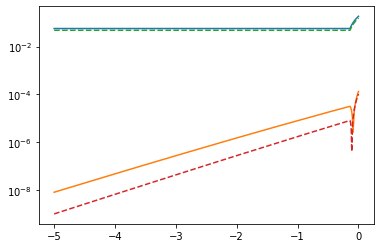

In [16]:
ztest=np.linspace(-5,0,500)
plt.semilogy(ztest, np.abs(ls.hNP(ztest)))
plt.semilogy(ztest, np.abs(ls.hNM(ztest)))
plt.semilogy(ztest, np.array([hPAvgTest(z) for z in ztest]),'--')
plt.semilogy(ztest, np.array([np.abs(hMAvgTest(z)) for z in ztest]),'--')


$\gamma$-averaging

In [17]:
def GammaAvgTest(zeta):
    m=ls.Mb/Tsph*np.exp(zeta)
    fN=1/(np.exp(np.sqrt(klist**2+m**2))+1)
    T=np.exp(-zeta)*Tsph
    gNPvec=gP(zeta)
    return np.dot(wlist,gNPvec*klist**2*fN*(1-fN))*12/(2*np.pi**2)

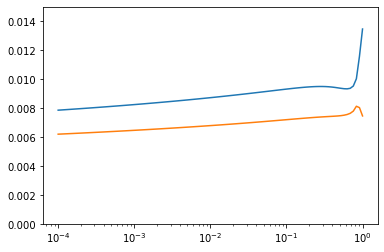

In [18]:
z=np.logspace(-4,0,100)
plt.semilogx(z, ls.gammanuP(np.log(z)))
plt.semilogx(z, [GammaAvgTest(ze) for ze in np.log(z)])
plt.ylim(0,0.015)
plt.show()

In [19]:
print(ls.gammanuP(-3))
print(GammaAvgTest(-3))

0.00911878728170657
0.007062871369166595


## Momentum-depentent ODE

### Yukawa matrices:

The current version cannibalizes old code for the Yukawa matrices.
This should be reimplemented as exemplified above.
Cannibalized Yukawas are not JIT-compatible.
Added a class to momentumDep that initializes the matrices,
for now it lacks the chi-multiplied washout rates (we might want to remove this "feature" anyway).

In [20]:
chi = -2 * (np.eye(3) * (257 - 20) + 20) / 711
# TODO: check this
#-1/16*np.dot(chi,yM.UpsPGnuN).T - yM.UpsWPGNnu

Interestingly enough - 2x faster without JIT!!!

In [21]:
#@jit
def Gamma(zeta):
    T=np.exp(-zeta)*Tsph
    #m=ls.Mb/T
    m=MHNL/T
    fN=1/(np.exp(np.sqrt(klist**2+m**2))+1)
    gNPvec=gP(zeta)
    gNMvec=gM(zeta)
    # LNC rates
    GPNN=np.kron(np.diag(gNPvec), yM.UpsPGNN)
    GPnuN=np.kron(1/(2*np.pi**2)*klist**2*gNPvec*wlist, yM.UpsPGnuN )
    GPNnu=np.kron(12*gNPvec*fN*(1-fN), yM.UpsWPGNnu.T).T
    GPnunu=np.dot(wlist, gNPvec*klist**2*fN*(1-fN))*12/(2*np.pi**2)*yM.UpsnunuChi
    # LNV rates
    GMNN=np.kron(np.diag(gNMvec), yM.UpsMGNN)
    GMnuN=np.kron(1/(2*np.pi**2)*klist**2*gNMvec*wlist, yM.UpsMGnuN)
    GMNnu=np.kron(12*gNMvec*fN*(1-fN), yM.UpsWMGNnu.T).T
    GMnunu=np.dot(wlist, gNMvec*klist**2*fN*(1-fN))*12/(2*np.pi**2)*yM.UpsnunuChi
    #return GPNN
    return np.block([[GPNN+GMNN, GPNnu+GMNnu],
                     [GPnuN+GMnuN, GPnunu+GMnunu]])*np.exp(zeta)

In [22]:
%timeit Gamma(-3)

195 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
def H(zeta):
    m=ls.Mb/Tsph*np.exp(zeta)
    En=np.sqrt(m**2+klist**2)
    #Hvac=np.kron(np.diag(1/En), np.exp(zeta*3)*0.5*yM.M2Hnn)
    Hvac=np.kron(np.diag(1/En), np.exp(zeta*3)*0.5*M2Hnn[:8,:8])
    return np.block([[Hvac, np.zeros([8*len(klist),3])],
                     [np.zeros([3,8*len(klist)]),np.eye(3)*0]])

In [24]:
def Hth(zeta):
    HthP=np.kron(np.diag(hp(zeta)), yM.UpsPHNN)
    HthM=np.kron(np.diag(hm(zeta)), yM.UpsMHNN)
    return np.block([[HthP + HthM, np.zeros([8*len(klist),3])],
                     [np.zeros([3,8*len(klist)]),np.eye(3)*0]])*np.exp(zeta)



### ODE:

In [25]:
def fode(x,zeta):
    GReg=np.dot(H(zeta) + Hth(zeta) -Gamma(zeta),np.linalg.inv( -(H(zeta))/1e5+np.eye(8*len(klist)+3)   ))
    #GReg=H(zeta)-Gamma(zeta)
    return np.dot(GReg,x)


In [26]:
y0=-1/(1+np.exp(klist))*Tsph**3/sent(Tsph)
y0N=np.append(np.kron(y0,np.array([1,1,0,0,0,0,0,0])),np.zeros(3))
y0

array([-6.62082840e-03, -3.58737387e-03, -1.77621556e-03, -8.36413502e-04,
       -3.84109057e-04, -1.74317853e-04, -7.86797173e-05, -3.54249461e-05,
       -1.59320075e-05, -7.16165455e-06])

In [27]:
%%time
Xsol=odeint(fode,y0N,zetaPlt, atol=1e-15, rtol=1e-6)


CPU times: user 3min 20s, sys: 1.36 s, total: 3min 22s
Wall time: 51.1 s


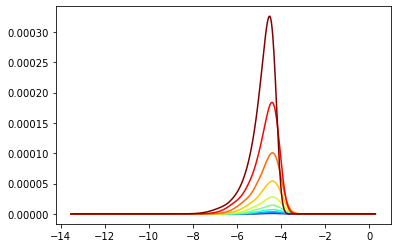

In [28]:
for i in reversed(range(Nmodes)):
    plt.plot(zetaPlt, Xsol[:,3+8*i],c=plt.cm.jet_r(i/Nmodes))

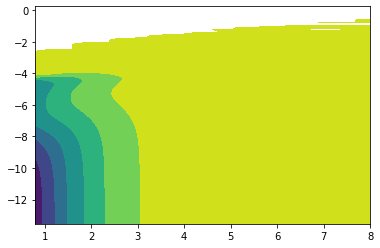

In [29]:
plt.contourf(klist, zetaPlt[:-1], Xsol[:-1,:-3][:,::8])

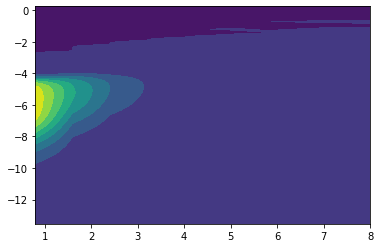

In [30]:
plt.contourf(klist, zetaPlt[:-1], Xsol[:-1,:-3][:,2::8])

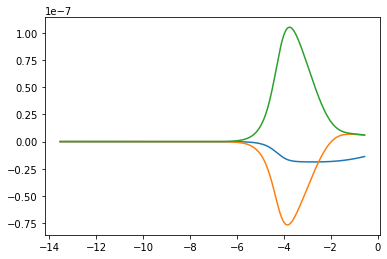

In [31]:
plt.plot(zetaPlt[:-30], Xsol[:-30,-3:])

[]

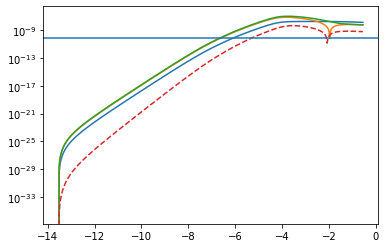

In [32]:
plt.semilogy(zetaPlt[:-30],np.abs(Xsol[:-30,-3:]))
plt.semilogy(zetaPlt[:-30],28/79*np.abs(np.sum(Xsol[:-30,-3:],axis=1)), '--')
plt.axhline(8.5e-11)
plt.plot()

In [33]:
28/79*np.abs(np.sum(Xsol[:-30,-3:],axis=1))[-1]

6.388337216072643e-10

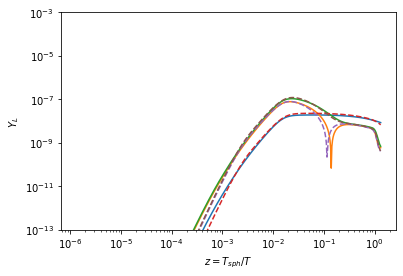

In [34]:
plt.loglog(np.exp(zetaPlt[:]),np.abs(Xsol[:,-3:]))
#plt.semilogy(zetaPlt[:],28/79*np.abs(np.sum(Xsol[:,-3:],axis=1)), '--')

plt.loglog(Tsph/ls.Tlist, 2*np.abs(ls.xsol[:,-3:]),'--')
plt.ylim(1e-13,1e-3)
plt.ylabel(r'$Y_L$')
plt.xlabel(r'$z=T_{sph}/T$')
plt.show()

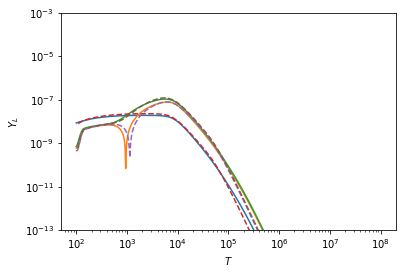

In [35]:
plt.loglog(Tsph/np.exp(zetaPlt[:]),np.abs(Xsol[:,-3:]))
#plt.semilogy(zetaPlt[:],28/79*np.abs(np.sum(Xsol[:,-3:],axis=1)), '--')

plt.loglog(ls.Tlist, 2*np.abs(ls.xsol[:,-3:]),'--')
plt.ylim(1e-13,1e-3)
plt.ylabel(r'$Y_L$')
plt.xlabel(r'$T$')
plt.show()

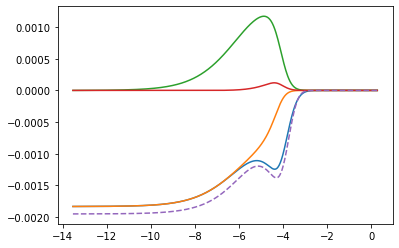

In [36]:
plt.plot(zetaPlt, np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,0::8].T))
plt.plot(zetaPlt, np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,1::8].T))
plt.plot(zetaPlt, np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,2::8].T))
plt.plot(zetaPlt, np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,3::8].T))

plt.plot(np.log(Tsph/ls.Tlist), ls.xsol[:,0], '--')

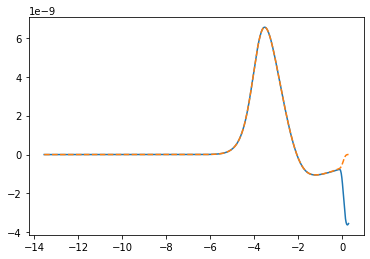

In [37]:
#plt.plot(t[:],Xsol[:,-3:])
#plt.plot(t[:],28/79*np.abs(np.sum(Xsol[:,-3:],axis=1)), '--')

plt.plot(zetaPlt, 1/2*np.sum(Xsol[:,-3:],axis=1), '-')
plt.plot(zetaPlt, np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,4::8].T + Xsol[:,:-3][:,5::8].T),'--')
#plt.plot(t, np.dot(wlist,Xsol[:,:-3][:,4::8].T))
#plt.plot(t, np.dot(wlist,Xsol[:,:-3][:,5::8].T))
#plt.plot(t,np.dot(wlist,Xsol[:,:-3][:,6::8].T))
#plt.plot(t,np.dot(wlist,Xsol[:,:-3][:,7::8].T))

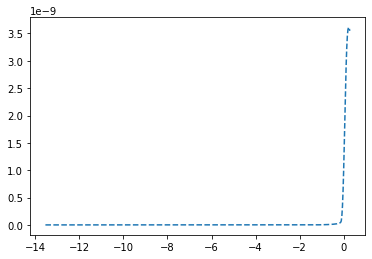

In [38]:
plt.plot(zetaPlt, -1/2*np.sum(Xsol[:,-3:],axis=1) + np.dot(wlist*klist**2/(2*np.pi**2), Xsol[:,:-3][:,4::8].T + Xsol[:,:-3][:,5::8].T),'--')

plt.show()


# ↓↓↓ Old code ↓↓↓
## Gauß-Laguerre Quadrature

In [39]:
kquad, wquad=np.polynomial.laguerre.laggauss(5)

In [40]:
#
#omegaQ=np.kron(np.diag(1/kquad),commutator2matrix(np.diag([1,-1])))
#gammaQ=np.kron(np.diag(kquad**0),anticommutator2matrix(np.array([[1,1],[1,1]])))
#
#def fodeQ(x,z):
#    return np.dot(0.5*omegaQ-0.05*gammaQ/2,x)
#
#
##%%
#
#y0Q=kquad**2/(1+np.exp(kquad))
#y0NQ=np.kron(y0Q,np.array([1,1,0,0]))
#
##%%
#
#XsolQ=odeint(fodeQ,y0NQ,t)
#
##%%
#
#plt.plot(t,np.trapz(Xsol[:,0::4],klist,axis=1))
#plt.plot(t,np.dot(XsolQ[:,::4],wquad*np.exp(kquad)),'--')
#
##%%
#
#plt.plot(t,np.trapz(Xsol[:,2::4],klist,axis=1))
#plt.plot(t,np.dot(XsolQ[:,2::4],wquad*np.exp(kquad)),'--')
#
#plt.plot(t,np.trapz(Xsol[:,3::4],klist,axis=1))
#plt.plot(t,np.dot(XsolQ[:,3::4],wquad*np.exp(kquad)),'--')
#
#
##%%
#
#np.polynomial.laguerre.laggauss(2)
#
##%%
#
